In [1]:
!pip install "gymnasium[atari,accept-rom-license]"


In [2]:
!pip install ale-py

In [3]:
!pip install -q tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.3 MB/s eta 0:00:00


In [9]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import argparse
import time
import numpy as np
import collections
from tensorboardX import SummaryWriter
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import collections

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super().__init__(env)
        self.n_steps = n_steps
        self.dtype = dtype
        self.frames = collections.deque(maxlen=n_steps)

        # AtariPreprocessing without channel_first=True outputs (H, W)
        obs_shape = env.observation_space.shape # (84, 84)
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(n_steps, obs_shape[0], obs_shape[1]), # Desired shape (4, 84, 84)
            dtype=dtype
        )

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs) # obs is (84, 84)
        # Initialize deque with the first observation repeated n_steps times
        for _ in range(self.n_steps):
            self.frames.append(obs)
        return self._get_observation(), info # Return observation and info

    def observation(self, observation): # observation is (84, 84)
        self.frames.append(observation)
        return self._get_observation()

    def _get_observation(self):
        # Stack frames along a new dimension (channel dimension) to get (n_steps, H, W)
        return np.stack(list(self.frames), axis=0).astype(self.dtype)

In [21]:
from gymnasium.wrappers import (
    AtariPreprocessing,
    TransformObservation,
    RecordEpisodeStatistics
)
env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array", frameskip=1)
# Apply AtariPreprocessing to convert to grayscale and resize frames
env = AtariPreprocessing(env, screen_size=84, grayscale_newaxis=False, scale_obs=True)
env = BufferWrapper(env, n_steps=4)

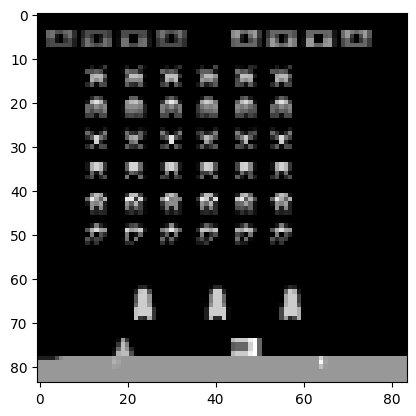

In [22]:
plt.imshow(env.reset()[0][0], cmap='gray')

___
#First DQN
___

In [23]:
class DQN(nn.Module):

  def __init__ (self, input_shape,n_actions):
    super(DQN,self).__init__()

    self.conv=nn.Sequential(
        nn.Conv2d(input_shape[0],32,kernel_size=8,stride=4),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=4,stride=2),
        nn.ReLU()   )

    conv_out_size=self._get_conv_out(input_shape)
    self.fc=nn.Sequential(
        nn.Linear(conv_out_size,512),
        nn.ReLU(),
        nn.Linear(512,n_actions)
    )


  def _get_conv_out(self,shape):
    zeros=self.conv(torch.zeros(1,*shape))
    return int(np.prod(zeros.size()))


  def forward(self,frames):
    conv_output=self.conv(frames)
    conv_output=conv_output.view(conv_output.size()[0],-1)
    return self.fc(conv_output)

___
# ReplayBuffer

___

In [24]:
ENV_NAME="ALE/SpaceInvaders-v5"
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 10000
REPLAY_START_SIZE = 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000
EPSILON_DECAY_LAST_FRAME = 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
DEFAULT_ENV_NAME = "ALE/SpaceInvaders-v5"
MEAN_REWARD_BOUND = 500

In [25]:
from os import replace
Experience= collections.namedtuple("Experience",field_names=['state','action','reward','done','new_state'])

class ExperienceBuffer():

  def __init__(self,capacity):
    self.buffer = collections.deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self,experience):
    self.buffer.append(experience)

  def sample(self,batch_size):
    examples=np.random.choice(len(self.buffer), batch_size, replace=False) # Corrected arguments for np.random.choice
    list_of_exp=[self.buffer[ex] for ex in examples]
    states, actions, rewards, dones, next_states= zip(*list_of_exp)
    return np.array(states), np.array(actions), np.array(rewards,dtype=np.float32), np.array(dones,dtype=np.uint8), np.array(next_states)

# The Agent
___

In [26]:
class Agent():
  def __init__(self,env,exp_buffer):
    self.env=env
    self.exp_buffer=exp_buffer
    self._reset()

  def _reset(self):
    self.state, _ = self.env.reset() # Fix: env.reset() returns (observation, info) in Gymnasium
    self.total_reward=0.0

  @torch.no_grad()
  def play_step(self,net,epsilon=0.0,device='cpu'):
    done_reward=None

    if np.random.random()<epsilon:
      action=self.env.action_space.sample()
    else:
      state_a=np.asarray([self.state]) # Fix: Replaced np.array(..., copy=False) with np.asarray
      state_v=torch.tensor(state_a).to(device)
      q_vals_v=net(state_v)
      _,act_v=torch.max(q_vals_v,dim=1)
      action=int(act_v.item())
    new_state,reward,terminated,truncated,info=self.env.step(action)
    is_done = terminated or truncated
    self.total_reward +=reward
    exp=Experience(self.state,action,reward,is_done,new_state)
    self.exp_buffer.append(exp)
    self.state=new_state
    if is_done:
      done_reward=self.total_reward
      self._reset() # Fix: Call _reset() method using self
    return done_reward

In [27]:
def calc_loss(batch,net,tgt_net,device='cpu'):
  states,actions,rewards,dones,next_states=batch
  states_v=torch.tensor(np.array(states,copy=False)).to(device)
  next_statges_v=torch.tensor(np.array(next_states,copy=False)).to(device)
  actions_v=torch.tensor(actions).to(device)
  rewards_v=torch.tensor(rewards).to(device)
  done_mask=torch.BoolTensor(dones).to(device)

  state_action_values=net(states_v).gather(1,actions_v.unsqueeze(-1)).squeeze(-1)
  next_state_values=tgt_net(next_statges_v).max(1)[0]
  next_state_values[done_mask]==0.0

  next_state_values=next_state_values.detach()
  expected_state_action_values=next_state_values*GAMMA+rewards_v
  return nn.MSELoss()(state_action_values,expected_state_action_values)


___
# The Training Part
___

In [32]:
import os

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--cuda", default=False,
                        action="store_true", help="Enable cuda")
    parser.add_argument("--env", default=DEFAULT_ENV_NAME,
                        help="Name of the environment, default=" +
                             DEFAULT_ENV_NAME)
    args = parser.parse_args(args=[])
    device=torch.device('cuda'if args.cuda else 'cpu')
    net=DQN(env.observation_space.shape,env.action_space.n).to(device)
    tgt_net=DQN(env.observation_space.shape,env.action_space.n).to(device)
    writer=SummaryWriter(comment='-'+ args.env)
    print(net)

    buffer=ExperienceBuffer(REPLAY_SIZE)
    agent=Agent(env,buffer)
    optimizer=torch.optim.Adam(net.parameters(),lr=LEARNING_RATE)

    total_rewards=[]
    frame_idx=0
    epsilon=EPSILON_START
    best_m_reward=None

    model_path = args.env.replace('/', '_') + "-best.dat"
    # Load saved model weights and training progress if they exist
    if os.path.exists(model_path):
        try:
            checkpoint = torch.load(model_path)
            # Check if it's the new checkpoint format (a dictionary with 'net_state_dict')
            if isinstance(checkpoint, dict) and 'net_state_dict' in checkpoint:
                net.load_state_dict(checkpoint['net_state_dict'])
                tgt_net.load_state_dict(checkpoint['net_state_dict'])
                frame_idx = checkpoint['frame_idx']
                best_m_reward = checkpoint['best_m_reward']
                epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)
                print(f"Loaded model weights and progress from {model_path} (frame_idx: {frame_idx}, best_m_reward: {best_m_reward:.3f})")
            else: # Assume it's the old format where only state_dict was saved directly
                net.load_state_dict(checkpoint)
                tgt_net.load_state_dict(checkpoint)
                print(f"Loaded old format model weights from {model_path}. Training progress (frame_idx, best_m_reward, epsilon) will start from default.")
                # Reset frame_idx and best_m_reward as they are not available in old format
                frame_idx = 0
                best_m_reward = None
                epsilon = EPSILON_START
        except Exception as e:
            print(f"Error loading model from {model_path}: {e}. Starting training from scratch.")
            # Ensure these are reset if loading fails or for old format
            frame_idx = 0
            best_m_reward = None
            epsilon = EPSILON_START

    # Load episode rewards history if the file exists
    episode_rewards_file_path = 'episode_rewards.txt'
    if os.path.exists(episode_rewards_file_path):
        with open(episode_rewards_file_path, 'r') as f:
            for line in f:
                try:
                    total_rewards.append(float(line.strip()))
                except ValueError:
                    continue # Skip invalid lines
        print(f"Loaded {len(total_rewards)} historical rewards from {episode_rewards_file_path}")

    ts_frame=0
    ts=time.time()

    # Open the file for appending new individual episode rewards
    episode_rewards_file = open(episode_rewards_file_path, 'a')

    try:
        while True:
            frame_idx+=1
            epsilon=max(EPSILON_FINAL,EPSILON_START-frame_idx/EPSILON_DECAY_LAST_FRAME)
            reward=agent.play_step(net,epsilon,device=device)
            if reward is not None:
                total_rewards.append(reward)
                # Save the individual episode reward to file
                episode_rewards_file.write(f"{reward}\n")
                episode_rewards_file.flush() # Ensure it's written to disk immediately

                speed = (frame_idx - ts_frame) / (time.time() - ts)
                ts_frame = frame_idx
                ts = time.time()
                m_reward = np.mean(total_rewards[-100:])
                print("%d: done %d games, reward %.3f, ""eps %.2f, speed %.2f f/s" % (frame_idx, len(total_rewards), m_reward, epsilon,speed))
                writer.add_scalar("epsilon", epsilon, frame_idx)
                writer.add_scalar("speed", speed, frame_idx)
                writer.add_scalar("reward_100", m_reward, frame_idx)
                writer.add_scalar("reward", reward, frame_idx)
                if best_m_reward is None or best_m_reward < m_reward:
                    checkpoint = {
                        'net_state_dict': net.state_dict(),
                        'frame_idx': frame_idx,
                        'best_m_reward': m_reward,
                    }
                    torch.save(checkpoint, model_path)
                    if best_m_reward is not None:
                        print("Best reward updated %.3f -> %.3f" % (best_m_reward, m_reward))
                    best_m_reward = m_reward
                if m_reward > MEAN_REWARD_BOUND:
                    print("Solved in %d frames!" % frame_idx)
                    break
            if len(buffer) < REPLAY_START_SIZE:
                continue

            if frame_idx % SYNC_TARGET_FRAMES == 0:
                tgt_net.load_state_dict(net.state_dict())
            optimizer.zero_grad()
            batch=buffer.sample(BATCH_SIZE)
            loss_t=calc_loss(batch,net,tgt_net,device=device)
            loss_t.backward()
            optimizer.step()
    finally:
        # Ensure the file is closed even if an error occurs or training stops
        episode_rewards_file.close()

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=5184, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Loaded old format model weights from ALE_SpaceInvaders-v5-best.dat. Training progress (frame_idx, best_m_reward, epsilon) will start from default.
Loaded 209 historical rewards from episode_rewards.txt
306: done 210 games, reward 175.100, eps 1.00, speed 845.48 f/s
885: done 211 games, reward 176.100, eps 0.99, speed 872.98 f/s
Best reward updated 175.100 -> 176.100
1554: done 212 games, reward 174.900, eps 0.99, speed 865.00 f/s
1993: done 213 games, reward 173.850, eps 0.99, speed 880.56 f/s
2715: done 214 games, reward 175.350, eps 0.98, speed 901.88 f/s
3413: done 215 games, reward 175.050, eps 0.98, speed 883.70 f/s
4008: done 216 games, rewa

KeyboardInterrupt: 